The previous linear regression used ordinary least squares (OLS). Now we use Gradient descent to find a more optimal approach  for parameter estimation.

I decide to use compare it to LASSO, since it uses a form of gradient descent ([Coordinate Descent](https://en.wikipedia.org/wiki/Coordinate_descent)) to converge at an answer. Let's see what we get.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
%matplotlib inline

In [2]:
from sklearn import linear_model, datasets

In [3]:
diabetes = datasets.load_diabetes()  # load dataset

### scikit learn method
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

In [4]:
diabetes_X = diabetes.data[:, np.newaxis, 2]  # reshape to column vector

# train data
train_X = diabetes_X[:-20]
test_X = diabetes_X[-20:]

# test data
train_y = diabetes.target[:-20][:, np.newaxis]
test_y = diabetes.target[-20:][:, np.newaxis]

# design model
reg = linear_model.Lasso(alpha = 0.1)

# estimate parameters
reg.fit(train_X, train_y)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [5]:
alphas = np.linspace(1e-4, 5, 20)

## What is gradient descent?

Good reference

http://ozzieliu.com/2016/02/09/gradient-descent-tutorial/

In [6]:
# add a column of ones to solve for y-intercept (beta-naught)

column_ones = np.ones((train_X.shape))
train_X = np.hstack((column_ones, train_X))

In [7]:
train_X.shape

(422, 2)

In [8]:
def loss_function(y_true, y_hat):
    '''
    Calculate the loss function J(beta) (in this case MSE) of some estimated parameters
    under a Lasso Regression analysis.
    
    J(beta) = (1/2m) * sum((y - X * betas) ** 2)
    
    where the sum runs from 1 to the number of beta parameters (i.e. len(y))
    '''
    #m = len(y_true)
    
    # calculate residuals
    residuals = y_true - y_hat

    # calculate loss for param
    loss =  np.mean(np.square(residuals)) / 2
    
    return loss

In [9]:
def gradient_descent(X, y, learning_rate=0.1, tol=0.001, max_iter=int(1e5)):
    '''
    
    '''
    
    # initialize
    m = len(y)
    loss_diff = 1
    iter_ = 0
    loss_history = np.empty(max_iter)
    
    # starting point for parameters
    beta = np.array([[500],[500]])
    beta_history = np.empty((max_iter, X.shape[1]))
    beta_history[iter_, :] = beta[:,0]
    
    while (loss_diff > tol) and (iter_ < max_iter):
        
        # calculate residuals
        y_hat = np.dot(X, beta)
        res = y_hat - y
        
        # calculate next parameter estimate
        gradient = np.dot(X.T, res) / m
        beta = beta - learning_rate * gradient
        
        # calculate loss
        y_hat = X.dot(beta) 
        loss = loss_function(y, y_hat)
        
        # update stop conditions
        iter_ +=1
        beta_history[iter_, :] = beta[:,0]
        loss_history[iter_] = loss
        loss_diff = abs(loss_history[iter_] - loss_history[iter_ - 1])
        
    return beta, loss_history[:iter_], iter_, beta_history[:iter_, :]

In [10]:
coef, loss_history, iters, beta_history = gradient_descent(train_X, train_y)

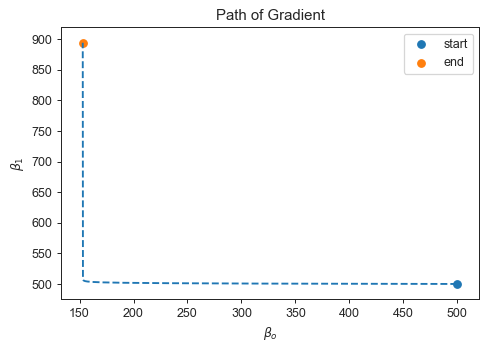

In [11]:
plt.figure(dpi=90)
plt.plot(beta_history[:,0], beta_history[:, 1], '--')
plt.scatter(beta_history[0][0], beta_history[0][1], label='start')
plt.scatter(beta_history[-1][0], beta_history[-1][1], label='end')
plt.xlabel(r'$\beta_o$')
plt.ylabel(r'$\beta_1$')
plt.title("Path of Gradient")
plt.legend()
plt.show()

It appears the gradient finds the y-intercept, $\beta_o$, quickly, but takes much longer to find the slope, $\beta_1$.

## Model Comparison

In [12]:
%precision 3

'%.3f'

In [13]:
print('Estimated coefficients\n')
print("Scikit-learn\t\t\t\tScratch Model")
print(f'{reg.intercept_[0], reg.coef_[0]}\t{coef[:,0]}')

Estimated coefficients

Scikit-learn				Scratch Model
(152.9397438303491, 894.080996097091)	[152.94  894.095]


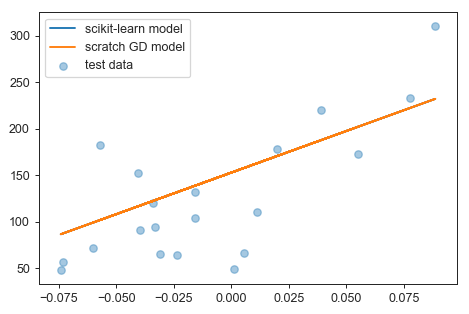

In [14]:
plt.figure(dpi=90)
plt.plot(test_X, (coef[0] + test_X * coef[1]), label='scikit-learn model')
plt.plot(test_X, (reg.intercept_ + test_X * reg.coef_), label='scratch GD model')
plt.scatter(test_X, test_y, label='test data', alpha=0.4)
plt.legend()
plt.show()

In [15]:
print('Iterations before converging:\n')
print("Scikit-learn\t\tScratch Model")
print(f'{reg.n_iter_}\t\t\t{iters}')

Iterations before converging:

Scikit-learn		Scratch Model
2			10136


Scikit-learn's converges the optimal parameters rapidly in comparision to the scratch model.

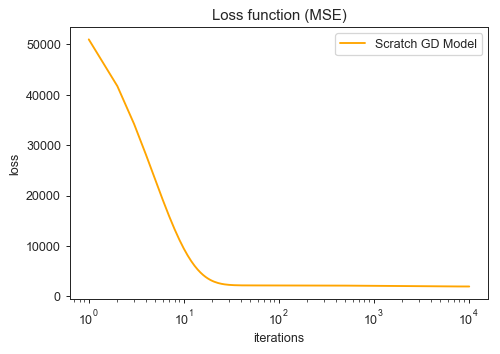

In [16]:
plt.figure(dpi=90)
plt.plot(np.linspace(1, iters, iters -1), loss_history[1:iters+1], color='orange', label='Scratch GD Model')
#plt.yscale("log")
plt.xscale("log")

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss function (MSE)')
plt.legend()
plt.show()
